# State Level Comparisons
This notebook is useful for comparing key COVID-19 statistics across a subset of states.

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [210]:
try:
    # read directly from NYT's github repo for the freshest data
    states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
except:
    # unless it's not available in which case read locally after pulling the repo from upstream
    # (assumes you've added the NYT repo as upstream with 
    #     $ remote add upstream https://github.com/nytimes/covid-19-data.git)
    !git pull upstream master
    states = pd.read_csv('us-states.csv')

In [211]:
states.drop(columns='fips',inplace=True)
states.head()

,date,state,cases,deaths
0,2020-01-21,Washington,1,0
1,2020-01-22,Washington,1,0
2,2020-01-23,Washington,1,0
3,2020-01-24,Illinois,1,0
4,2020-01-24,Washington,1,0


In [212]:
# compute the new cases and new deaths per state
start = '2020-01-20'
los = states.state.unique()
for state in los:
    tmp = pd.concat([pd.DataFrame([{'state': state, 'date': start, 'cases': 0, 'deaths': 0}]),states[states.state == state]])
    # compute new cases and deaths
    states.loc[tmp.index,'new_cases'] = tmp['cases'] - tmp['cases'].shift(1)
    states.loc[tmp.index,'new_deaths'] = tmp['deaths'] - tmp['deaths'].shift(1)

In [213]:
states.head()

,date,state,cases,deaths,new_cases,new_deaths
0,2020-01-21,Washington,1,0,NaN,NaN
1,2020-01-22,Washington,1,0,0.0,0.0
2,2020-01-23,Washington,1,0,0.0,0.0
3,2020-01-24,Illinois,1,0,1.0,0.0
4,2020-01-24,Washington,1,0,0.0,0.0


In [223]:
# get state populations and other variables
state_populations = pd.read_csv('state population and area.csv')
state_populations.head()

,State,TotalArea,LandArea,WaterArea,Density,Pop
0,Alaska,665384,570641,94743,1.2863,734002
1,Texas,268596,261232,7365,112.8204,29472295
2,California,163696,155779,7916,256.3727,39937489
3,Montana,147040,145546,1494,7.4668,1086759
4,New Mexico,121590,121298,292,17.2850,2096640


In [247]:
state_totals = states.groupby('state')\
    .agg({'deaths': max, 'cases': max})\
    .merge(state_populations,left_index=True,right_on='State')[['State','Pop','deaths','cases']]
state_totals.set_index('State',inplace=True)
state_totals['cfr'] = state_totals['deaths'] / state_totals['cases']
state_totals['deaths_per_million'] = 1E6*state_totals['deaths'] / state_totals['Pop']
state_totals['% infected'] = 100 * state_totals['cases'] / state_totals['Pop']
state_totals.head()

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
Alabama,4908621,78,2838,0.027484,15.890410,0.057817
Alaska,734002,5,233,0.021459,6.811971,0.031744
Arizona,7378494,89,3018,0.029490,12.062082,0.040903
Arkansas,3038999,21,1146,0.018325,6.910170,0.037710
California,39937489,548,20191,0.027141,13.721444,0.050557


In [214]:
# function to space the tick labels on the x axis and optionally rotate them
def space_x_ticks(ax,n,rotation=0):
    xticks=ax.xaxis.get_major_ticks()
    for i in range(len(xticks)):
        if i%n != 0:
            xticks[i].set_visible(False)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=rotation)

In [239]:
# function to make a 2x2 grid of plots showing new and total cases and deaths for a list of states
def compare_states(los):
    tmp = states.loc[states.state.isin(los)]
    
    #find the earliest date when any state in the list had 10 total cases
    start = tmp.loc[tmp.cases >= 10,'date'].min()
    tmp = tmp[tmp.date >= start]
    fig, ax = plt.subplots(2, 2, sharex='col',figsize=(10,8))
    fig.suptitle('COVID-19 Counts', fontsize=14, y=1.05);
    plt.tight_layout(pad=0.4, w_pad=0, h_pad=1.0)
    
    # top left
    sns.lineplot(x=tmp.date,y=tmp.new_cases,hue=tmp.state,ax=ax[0,0])
    ax[0,0].set_ylabel('Cases')
    ax[0,0].set_title('New per Day')
    ax[0,0].set_yscale('log')
    space_x_ticks(ax[0,0],7,45)
    ax[0,0].grid(True,axis='both')
    ax[0,0].tick_params(axis='x',direction='in')
    
    # top right
    sns.lineplot(x=tmp.date,y=tmp.cases,hue=tmp.state,ax=ax[0,1],legend=False)
    ax[0,1].get_yaxis().label.set_visible(False)
    ax[0,1].set_title('Total')
    ax[0,1].set_yscale('log')
    space_x_ticks(ax[0,1],7,45)
    ax[0,1].grid(True,axis='both')
    ax[0,1].tick_params(axis='x',direction='in')
    
    # bottom left
    sns.lineplot(x=tmp.date,y=tmp.new_deaths,hue=tmp.state,ax=ax[1,0],legend=False)
    ax[1,0].set_ylabel('Deaths')
    ax[1,0].set_yscale('log')
    space_x_ticks(ax[1,0],7,45)
    ax[1,0].grid(True,axis='both')
    ax[1,0].tick_params(axis='x',direction='in')
    
    # bottom right
    sns.lineplot(x=tmp.date,y=tmp.deaths,hue=tmp.state,ax=ax[1,1],legend=False)
    ax[1,1].get_yaxis().label.set_visible(False)
    ax[1,1].set_yscale('log')
    space_x_ticks(ax[1,1],7,45)
    ax[1,1].grid(True,axis='both')
    ax[1,1].tick_params(axis='x',direction='in')
    
    display(HTML(state_totals.loc[state_totals.index.isin(los)].to_html()))

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
California,39937489,548,20191,0.027141,13.721444,0.050557
Oregon,4301089,44,1321,0.033308,10.229967,0.030713
Washington,7797095,478,9608,0.049750,61.304883,0.123225


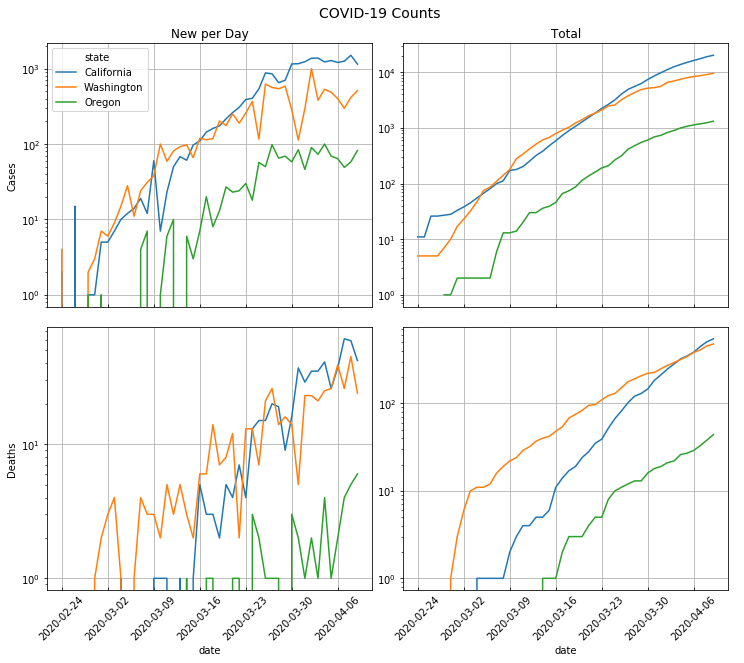

In [248]:
compare_states(['California','Oregon','Washington'])

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
Illinois,12659682,534,16422,0.032517,42.181154,0.129719
Indiana,6745354,246,6351,0.038734,36.469546,0.094154
Michigan,10045029,1076,21375,0.050339,107.117660,0.212792
Ohio,11747694,213,5512,0.038643,18.131218,0.046920


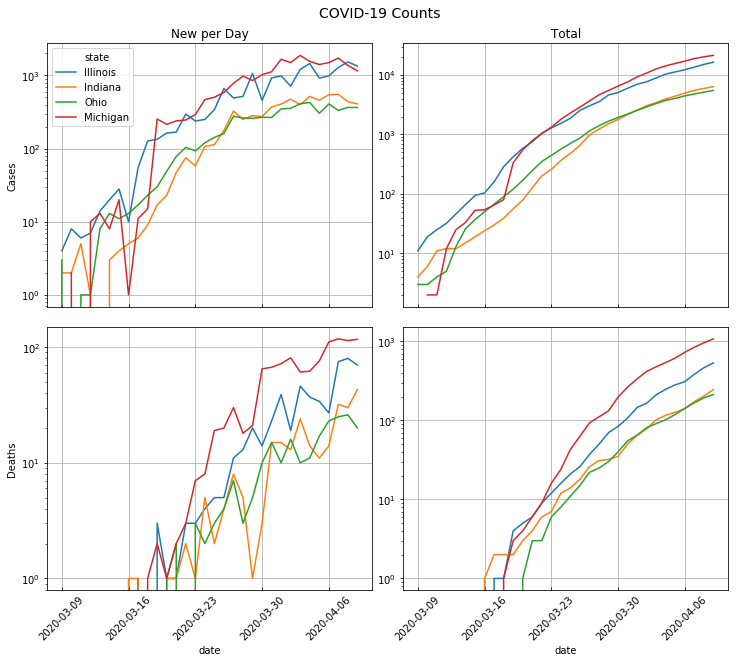

In [250]:
compare_states(['Michigan','Ohio','Illinois','Indiana'])

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
California,39937489,548,20191,0.027141,13.721444,0.050557
New York,19440469,7067,159937,0.044186,363.520036,0.822701


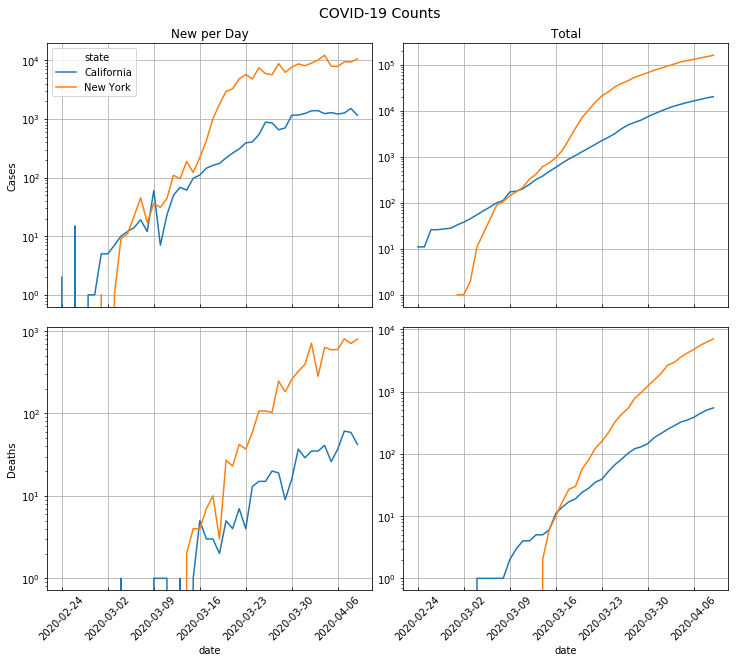

In [251]:
compare_states(['California','New York'])

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
New Jersey,8936574,1700,51027,0.033316,190.229500,0.570991
New York,19440469,7067,159937,0.044186,363.520036,0.822701


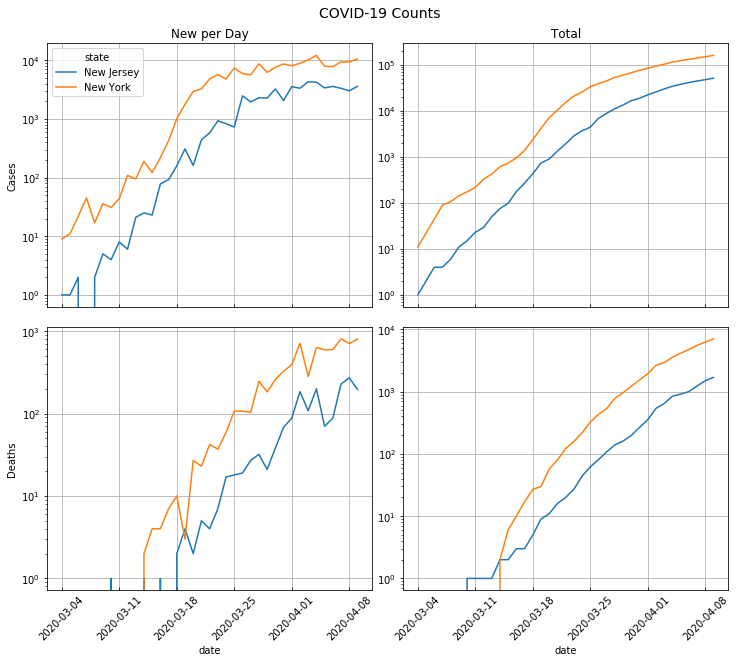

In [252]:
compare_states(['New York','New Jersey'])

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
Louisiana,4645184,702,18283,0.038396,151.124261,0.393590
South Carolina,5210095,67,2792,0.023997,12.859650,0.053588


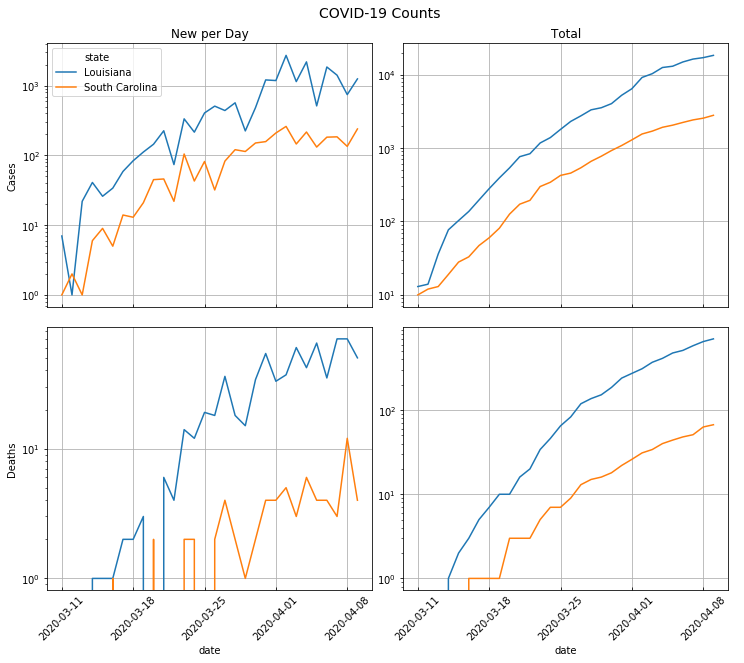

In [253]:
compare_states(['Louisiana','South Carolina'])

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
California,39937489,548,20191,0.027141,13.721444,0.050557
Colorado,5845526,227,6202,0.036601,38.833118,0.106098


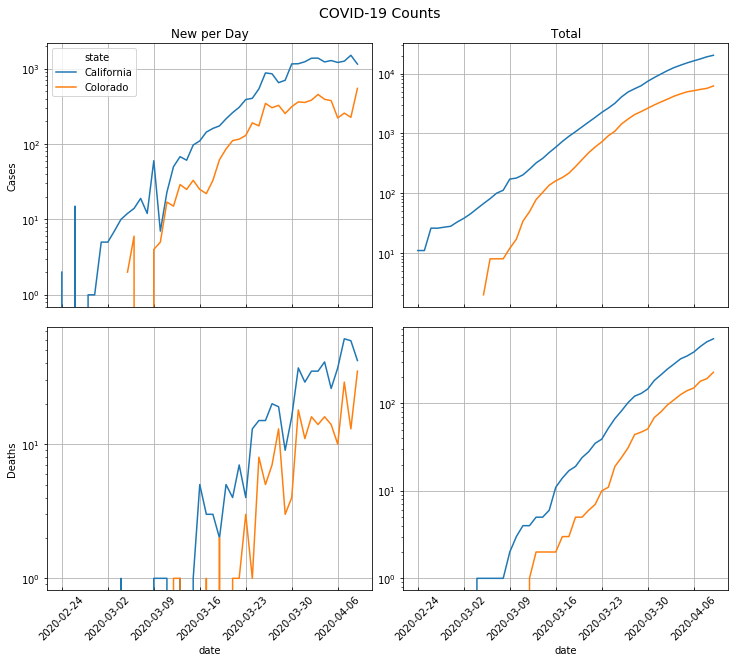

In [254]:
compare_states(['California','Colorado'])

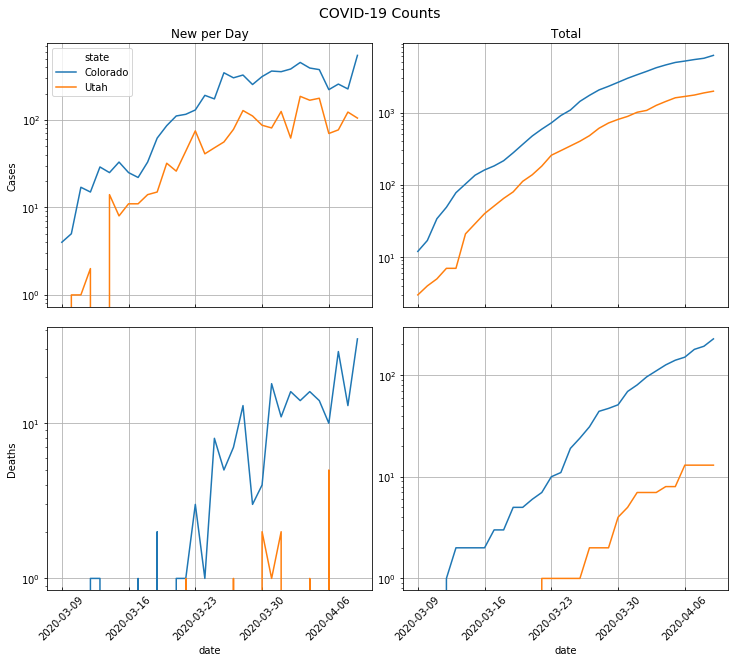

In [222]:
compare_states(['Utah','Colorado'])